In [1]:

import seaborn as sns
import metapack as mp
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display 

from demosearch import FileCache
from pathlib import Path

%matplotlib inline
sns.set_context('notebook')
mp.jupyter.init()

In [2]:
#pkg = mp.jupyter.open_package()
pkg = mp.jupyter.open_source_package()

pkg_root = Path(pkg.path).parent
cache = FileCache(pkg_root.joinpath('data/cache'))

pkg

# San Diego Business Clusters
`sandiegodata.org-business_clusters-1.3.2` Last Update: 2021-03-23T20:21:58

_Business in San Diego linked to entertainment clusters and population density._


This dataset processes the City of San Diego Master Business file to add
geocoded addresses and links to business clusters. San Diego publishes two
lists of businesses, which are based on payment of the San Diego City business
tax: the Master Business File, and a [SANGIS file that includes geographic
information.
](https://data.sandiegodata.org/dataset/sangis-org-business-sites/) Unfortunatel
y, these files are quite different and cannot be linked. The SANGIS file is
oriented toward the tax assessors parcel that the business occupies, and the
Master Business List has account numbers and addresses, but there is no common
key between the files.

The files in this package add address geocodes to the Master Business List, and
links the businesses to clusters of businesses. The Clusters are created by
collecting nearby businesses from Open Street Map data. The cluster types are:

* NA: No cluster, 31787 businesses
* shop: OSM tags 'shop', 'clothes', 'supermarket', 'bank', 'laundry', 'parking',  14615 businesses
* ent: Entertainment, OSM tags 'cafe', 'restaurant', 'bar', 14320 businesses
* casual: Fast food and convenience stores, OSM tags  'fast_food', 'convenience', 10991 businesses

The ``sd_business_clusters`` file has the clusters and their WKT geographies.
The ``sd_custered_businesses`` links San Diego businesses to clusters, and a
single business may be in more than one cluster because the clusters of
different types overlap. The `sd_ucustered_businesses` has the businesses deduplicated, with a business that is in multiple clusters taking only one cluster, in this order, from highest to lowest preference: 'ent', 'shop', 'casual','NA'

## NAICS Codes

It appears that the  NAICS codes used in the Master Business List are vintage 2007. The code '72221' appears frequently, which is valid in 2007 NAICS, but not in 2012 or 2016 NAICS. 

## Geocoding

The geocoding was performed with a local installation of Pelias. There are some notable errors in the geocoding. For instance, Ba Ho Liquor and Deli, with address of '4031 AVATI DR SUITE I SAN DIEGO 92117-4403, CA', was geocoded to 4144 Avati, moving the location from a neighborhood mini-mall to a residence. It is unknown how many such error there are, so use the geocodes with caution.


 

## Contacts

* **Wrangler** [Eric Busboom](mailto:eric@civicknowledge.com), [Civic Knowledge](http://civicknowledge.com)

## Resources

* ** [sb_mbl](notebooks/Extract.ipynb#sb_mbl)**. Businesses registered in San DIego, from the Master BusinessList
* ** [sd_business_clusters](notebooks/Extract.ipynb#sd_business_clusters)**. Geographic boundaries of business clusters
* ** [sd_businesses](notebooks/Extract.ipynb#sd_businesses)**. San Diego Businesses, geocoded
* ** [sd_clustered_businesses](notebooks/Extract.ipynb#sd_custered_businesses)**. San Diego Businesses, geocodes and linked to clusters. Businesses in multiple clusters are duplicated
* ** [sd_uclustered_businesses](notebooks/Extract.ipynb#sd_ucustered_businesses)**. San Diego Businesses, geocodes and linked to clusters. Businesses in multiple clusters are not duplicated
* ** [naics](notebooks/Extract.ipynb#naics)**. Naics codes for San Diego businesses
* ** [blockgroups](notebooks/Extract.ipynb#blocks)**. Geo data for census block groups and total population
* ** [bid](notebooks/Extract.ipynb#bid)**. San Diego Business Improvement Districts

## References
<ul><li> <strong>business_clusters</string>, <em>index:civicknowledge.com-osm-demosearch-2.1.1#business_clusters</em>. US business clusters</li><li> <strong><a href="https://www.sandiego.gov/sites/default/files/tr_active1.csv">sd_businesses_ak</a></strong>. San Diego Businesses A-K</li><li> <strong><a href="https://www.sandiego.gov/sites/default/files/tr_active2.csv">sd_businesses_lz</a></strong>. San Dieg

In [3]:
t = pkg.reference('naics_index_2007_26').dataframe()
t.columns = ['seq','naics_code','naics_desc','a','b','c']
naics = t

def int_maybe(v):
    try:
        return int(v)
    except:
        return v

naics_map = { int_maybe(r.naics_code):r.naics_desc for idx, r in naics.iterrows()}

In [4]:
sd_county = pkg.reference('sd_county_boundary').geoframe()
bs = pkg.reference('business_sites').geoframe()
bc = pkg.reference('business_clusters').geoframe()

In [5]:
sdb_ak = pkg.reference('sd_businesses_ak').dataframe()
sdb_lz = pkg.reference('sd_businesses_lz').dataframe()

sdb = pd.concat([sdb_ak, sdb_lz])
sb_mbl = sdb # The name in the metadata
sdb.head()

,BUSINESS ACCT#,DBA NAME,OWNERSHIP TYPE,ADDRESS,CITY,ZIP,STATE,BUSINESS PHONE,OWNER NAME,CREATION DT,START DT,EXP DT,NAICS,ACTIVITY DESC
0,2020002344,#0205,LLC,4704 IMPERIAL AVE,SAN DIEGO,92113-5001,CA,(619) 436-5006,CF UNITED CVX HOLDINGS LLC,02/07/2020,11/14/2019,11/30/2021,44711,GASOLINE STATIONS WITH CONVENIENCE STORES
1,2019021709,#1 FIFTH AVE,LLC,3845 05TH AVE,SAN DIEGO,92103-3140,CA,(619) 299-1911,ICONIC BAR INVESTMENTS LLC,10/15/2019,10/11/2019,10/31/2021,72241,DRINKING PLACES (ALCOHOLIC BEVERAGES)
2,2019010605,#OOHMAMAMACARONS,SOLE,515 S SAN JACINTO DR,SAN DIEGO,92114-5331,CA,NaN,YESENIA RAMIREZ,05/17/2019,05/16/2019,05/31/2021,72234,COTTAGE FOOD OPERATOR
3,2015046247,& SALLY J FERNANDEZ,SOLE,17471 PLAZA CERADO SUITE 98,SAN DIEGO,92128-2285,CA,NaN,JAIME V FERNANDEZ,10/29/2015,01/01/2014,12/31/2021,541219,OTHER ACCOUNTING SERVICES
4,2018011836,(W)RIGHT ON COMMUNICATIONS INC,SCORP,1200 PROSPECT ST SUITE G100,LA JOLLA,92037-3608,CA,(858) 866-7900,(W)RIGHT ON COMMUNICATIONS INC,06/22/2018,06/01/2018,05/31/2021,54182,PUBLIC RELATIONS AGENCIES


In [6]:
nl = pd.DataFrame( {
    'account' :sb_mbl['BUSINESS ACCT#'],
    'naics'   :sb_mbl['NAICS'],
    'naics_2' :sb_mbl['NAICS'].astype(str).str.slice(0,2),
    'naics_3' :sb_mbl['NAICS'].astype(str).str.slice(0,3),
    'naics_4' :sb_mbl['NAICS'].astype(str).str.slice(0,4),
    'naics_5' :sb_mbl['NAICS'].astype(str).str.slice(0,5),
    'naics_6' :sb_mbl['NAICS'].astype(str).str.slice(0,6),
})

for c in nl.columns[1:]:
    dc = c+"_desc"
    nl[dc] = nl[c].apply(lambda v: naics_map.get(int_maybe(v)) )

naics = nl

In [7]:
naics_map.get(72241)

'Drinking Places (Alcoholic Beverages)'

In [8]:
t  = gpd.sjoin(bc, sd_county)
sd_business_clusters = t[['cluster_n','geometry']]

In [9]:
#http://barker:4000/v1/search?text=1370%20Wilbur,%20San%20Diego,%20CA
import requests
import urllib.parse
import hashlib 
from demosearch.util import run_mp
def geocode(cache, text):
    
    text_enc = urllib.parse.quote_plus(text)
    text_h = hashlib.sha224(text_enc.encode('utf8')).hexdigest()
    
    key = f"geocode/{text_h[0:2]}/{text_h[2:4]}/{text_h}"
    
    if cache.exists(key):
        return cache.get(key)
    else:
        r = requests.get('http://barker:4000/v1/search?text='+text_enc)
        r.raise_for_status()
        j = r.json()
        
        cache.put(key, j)
        return j
    
def geocode_chunk(cache, frame_key):
    from time import sleep
    from random import uniform
    
        
    df = cache.get(frame_key)
    results = []
    for idx, row in df.iterrows():
        addr = f"{row.ADDRESS} {row.CITY} {row.ZIP}, {row.STATE}"
    
        sleep_time = 1
        for i in range(3):
    
            try:
                j = geocode(cache, addr)
                r = j['features'][0]['geometry']
            except IndexError as e:
                
                break
            except Exception as e:
                if e.response is not None and e.response.status_code == 400:
                    print("Timeout: Iter",i,' sleep', sleep_time, e)
                    sleep(sleep_time+uniform(0,3))
                    sleep_time *= 2
                       
                else:
                    r = e
                    break
            
        results.append( (row['BUSINESS ACCT#'], addr, r))

    return results

chunk_size = int(len(sdb)/100)


frames = [sdb[i:i+chunk_size] for i in range(0,sdb.shape[0],chunk_size)]
tasks = []
for i, f in enumerate(frames):
    key =  f'chunks/{i}'
    
    cache.put_df(key, f)
    tasks.append( (cache, key))

print("Start MP run")
r = run_mp(geocode_chunk, tasks, n_cpu=4)

from itertools import chain
import geopandas as gpd
rows = [ (e[0],e[1],e[2]['coordinates'][1], e[2]['coordinates'][0]) for e in list(chain(*r))]

gcodes = pd.DataFrame(rows, columns='account gc_address lat lon'.split())
gcodes['geometry'] = gpd.points_from_xy(gcodes.lon, gcodes.lat)
gcodes = gpd.GeoDataFrame(gcodes, crs=4326)

t = gcodes.merge(sdb, left_on='account', right_on='BUSINESS ACCT#')
t  = gpd.sjoin(t, sd_county)

Start MP run


  0%|          | 0/101 [00:00<?, ?it/s]

In [10]:
cols = ['account', 'gc_address', 'lat', 'lon',  'DBA NAME', 'OWNERSHIP TYPE',
         'CREATION DT', 'START DT', 'EXP DT', 'OWNER NAME','NAICS', 'ACTIVITY DESC', 'geometry']
sd_businesses = t[cols]

In [11]:
blocks = pkg.reference('census_bg').geoframe()
pop =  pkg.reference('total_population').dataframe()
t = blocks.merge(pop.reset_index())
cols = ['geoid',  'aland','b01003_001', 'intptlat', 'intptlon', 'geometry']
blocks = t[cols].rename(columns={'b01003_001':'pop', "aland":'area'}).to_crs(4326)


In [12]:
# Merge blockgroup population into sd_businesses
from geoid.censusnames import stusab
import rowgenerators as rg


t = gpd.sjoin(sd_businesses, blocks)
sd_businesses = t[list(sd_businesses.columns) + ['geoid','pop', 'area']]

sd_businesses.head()

,account,gc_address,lat,lon,DBA NAME,OWNERSHIP TYPE,CREATION DT,START DT,EXP DT,OWNER NAME,NAICS,ACTIVITY DESC,geometry,geoid,pop,area
0,2020002344,"4704 IMPERIAL AVE SAN DIEGO 92113-5001, CA",32.704439,-117.093248,#0205,LLC,02/07/2020,11/14/2019,11/30/2021,CF UNITED CVX HOLDINGS LLC,44711,GASOLINE STATIONS WITH CONVENIENCE STORES,POINT (-117.09325 32.70444),15000US060730033041,1822,221763
587,2013065112,"4455 49TH ST SUITE H SAN DIEGO 92115-4615, CA",32.705465,-117.089398,A R L PRODUCTIONS,SOLE,11/15/2013,11/05/2013,11/30/2021,ALBERT R LABOMBARD,54192,PHOTOGRAPHIC SERVICES,POINT (-117.08940 32.70546),15000US060730033041,1822,221763
4749,2003015184,"110 47TH ST SAN DIEGO 92102-4810, CA",32.704586,-117.094055,B & T JEWELRY REPAIR,H-W,05/21/2003,10/01/2002,09/30/2021,BOUTSABA SYHABANTHOM & TA INTHAVONG,541,"PROFESSIONAL, SCIENTIFIC & TECHNICAL SERVICES",POINT (-117.09405 32.70459),15000US060730033041,1822,221763
5740,2016007077,"4866 MAHOGANY VISTA LN SAN DIEGO 92102-4899, CA",32.705583,-117.090257,BERHE TADESSE TADEG,SOLE,06/02/2016,06/02/2016,06/30/2021,BERHE TADESSE TADEG,48531,TAXI SERVICE,POINT (-117.09026 32.70558),15000US060730033041,1822,221763
9398,2007004383,"4328 49TH ST SUITE A SAN DIEGO 92115-5013, CA",32.705465,-117.089398,CHINH HUYNH,SOLE,04/19/2007,04/19/2007,04/30/2021,CHINH HUYNH,56173,LANDSCAPING SERVICES,POINT (-117.08940 32.70546),15000US060730033041,1822,221763


In [15]:
t = gpd.sjoin(sd_businesses, sd_business_clusters, how='left')
cols = ['account', 'gc_address', 'lat', 'lon', 'geoid', 'pop', 'area', 'DBA NAME', 'OWNERSHIP TYPE',
         'CREATION DT', 'START DT', 'EXP DT', 'OWNER NAME','NAICS', 'ACTIVITY DESC', 
        'cluster_n','geometry']
t['cluster_n'] = t.cluster_n.fillna(0)
sd_custered_businesses = t[cols]


<AxesSubplot:>

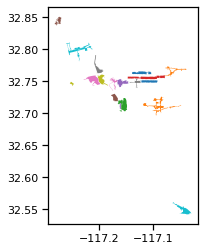

In [16]:
bid = pkg.reference('bid').geoframe().to_crs(4326)
bid = bid[['NAME2','SYMBOL', 'geometry']].rename(columns={'NAME2':'bid_name','SYMBOL':'bid_code'})
bid.plot(column='bid_name')


In [17]:
t = gpd.sjoin(sd_custered_businesses, bid, how='left').drop(columns=['index_right'])
sd_custered_businesses = t[ [c for c in t.columns if c != 'geometry'] + ['geometry']]

In [18]:
sd_custered_businesses.head().T

,0,587,4749,5740,9398
account,2020002344,2013065112,2003015184,2016007077,2007004383
gc_address,"4704 IMPERIAL AVE SAN DIEGO 92113-5001, CA","4455 49TH ST SUITE H SAN DIEGO 92115-4615, CA","110 47TH ST SAN DIEGO 92102-4810, CA","4866 MAHOGANY VISTA LN SAN DIEGO 92102-4899, CA","4328 49TH ST SUITE A SAN DIEGO 92115-5013, CA"
lat,32.7044,32.7055,32.7046,32.7056,32.7055
lon,-117.093,-117.089,-117.094,-117.09,-117.089
geoid,15000US060730033041,15000US060730033041,15000US060730033041,15000US060730033041,15000US060730033041
pop,1822,1822,1822,1822,1822
area,221763,221763,221763,221763,221763
DBA NAME,#0205,A R L PRODUCTIONS,B & T JEWELRY REPAIR,BERHE TADESSE TADEG,CHINH HUYNH
OWNERSHIP TYPE,LLC,SOLE,H-W,SOLE,SOLE
CREATION DT,02/07/2020,11/15/2013,05/21/2003,06/02/2016,04/19/2007


In [25]:
!pwd


/Users/eric/proj/code-projects/radius-search/data/sandiegodata.org-business_clusters/notebooks
